In [1]:
import pytorch_lightning as L
from pytorch_lightning.callbacks import ModelCheckpoint
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset  # Import Dataset
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import imageio as iio

from PIL import Image
import os
import sys
from pathlib import Path

from torch.utils.data import random_split,  DataLoader, Dataset

import torch.nn as nn
import torch.nn.functional as F
import datetime
import math

In [2]:
# dimm_x = 93
# dimm_y = 261


dimm_x = 125
dimm_y = 269


def MSRInitializer(Layer, ActivationGain=1):
    FanIn = Layer.weight.data.size(1) * Layer.weight.data[0][0].numel()
    Layer.weight.data.normal_(0,  ActivationGain / math.sqrt(FanIn))

    if Layer.bias is not None:
        Layer.bias.data.zero_()
    
    return Layer

class MineSequential(nn.Sequential):
    def __init__(self, *args, **kwargs):
        if len(args):
            super(MineSequential, self).__init__(args)
        else:
            super(MineSequential, self).__init__()

    def append(self, layer):
        if hasattr(layer,'reset_parameters'):
            layer.reset_parameters()
            layer = MSRInitializer(layer)
        super().append(layer)

    def reset(self):
        for module in self: # Iterate through modules
            if hasattr(module, 'reset_parameters'):
                module.reset_parameters()

In [3]:
def cosine_decay_with_warmup(cur_nimg, base_value, total_nimg, final_value=0.0):
    decay = 0.5 * (1 + np.cos(np.pi * (cur_nimg) / float(total_nimg)))
    cur_value = base_value + (1 - decay) * (final_value - base_value)
    return float(np.where(cur_nimg > total_nimg, final_value, cur_value))

In [14]:
class RGBAImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.png') or f.endswith('.jpg')]
        self.real_len = len(self.image_files)

    def __len__(self):
        return self.real_len * 20

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[ idx % self.real_len ])
        # image = Image.open(img_path).convert('RGBA')  # Ensure RGBA format
        image = Image.open(img_path).convert('RGBA')  # Ensure RGBA format
        if self.transform:
            image = self.transform(image)
        return image

In [55]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = MineSequential()
        self.model.append( nn.Conv2d(4, 16, kernel_size=4, stride=2, padding=1) )  # Output: 63x134
        self.model.append( nn.LeakyReLU(0.2) )
        self.model.append( nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1) )  # Output: 32x67
        self.model.append( nn.LeakyReLU(0.2) )
        self.model.append( nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1) )  # Output: 16x34
        self.model.append( nn.LeakyReLU(0.2) )
        self.model.append( nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1) ) # Output: 8x17
        self.model.append( nn.LeakyReLU(0.2) )
        self.model.append( nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1) ) # Output: 4x9
        self.model.append( nn.LeakyReLU(0.2) )
        self.model.append( nn.Flatten() )
        self.model.append( nn.Linear(6144, 1) )  # Corrected input size
        self.model.append( nn.Sigmoid() )

    def forward(self, x):
        return self.model(x)

class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        self.model = MineSequential()
        self.model.append( nn.Linear(latent_dim, 16 * 4 ) )
        self.model.append( nn.ReLU() )
        self.model.append( nn.Linear(16*4, 32 * 4 ) )
        self.model.append( nn.ReLU() )
        self.model.append( nn.Unflatten(1, (32, 1, 4)) )  # Reshape
        self.model.append( nn.ConvTranspose2d(32, 32, kernel_size=5, stride=3, padding=0) )
        self.model.append( nn.ReLU() )
        self.model.append( nn.ConvTranspose2d(32, 32, kernel_size=5, stride=2, padding=0) )
        self.model.append( nn.ReLU() )
        self.model.append( nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2, padding=0) )
        self.model.append( nn.ReLU() )
        self.model.append( nn.ConvTranspose2d(16, 8, kernel_size=5, stride=2, padding=0) )
        self.model.append( nn.ReLU() )
        self.model.append( nn.ConvTranspose2d(8, 4, kernel_size=5, stride=2, padding=0) )
        self.model.append( nn.ReLU() )
        self.model.append( nn.Conv2d(4, 4, kernel_size=1, padding=0) )
        self.model.append( nn.Tanh() )
        

    def forward(self, x):
        x = self.model(x)
        return x

In [6]:
import time
from IPython import display

from torchvision.transforms import ToPILImage
from IPython.display import Image as IPythonImage

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

to_img = ToPILImage(mode='RGBA')

In [58]:
class GAN(L.LightningModule):
    def __init__(self, latent_dim=10, lr=0.002, data_dir='images'):
        super().__init__()
        self.save_hyperparameters()
        self.generator = Generator(latent_dim=self.hparams.latent_dim)
        self.discriminator = Discriminator()
        self.validation_z = torch.randn(6, self.hparams.latent_dim)
        self.automatic_optimization = False  # Set to False for manual optimization
        self.setup_gamma()

    def setup_gamma(self):
        self.cur_nimg = 0
        self.gamma = {}
        self.gamma["base_value"] = 150
        self.gamma["final_value"] = 15
        self.gamma["total_decay"] = 100000

    def forward(self, z):
        return self.generator(z)
    
    @staticmethod
    def adversarial_loss_old(self, y_hat, y):
        # Ensure y is the same size as y_hat
        # if y.size(0) != y_hat.size(0):
        #     y = y[:y_hat.size(0)]  # Adjust y to match the size of y_hat
        return F.binary_cross_entropy(y_hat, y)
    
    @staticmethod
    def ZeroCenteredGradientPenalty(Samples, Critics):
        Gradient, = torch.autograd.grad(outputs=Critics.sum(), inputs=Samples, create_graph=True)
        return Gradient.square().sum([1, 2, 3])

    def training_step(self, batch, batch_idx):
        real_images = batch
        real_images = real_images.type(torch.float32)
        # print("real_images shape:", real_images.shape)

        # Access optimizers
        opt_g, opt_d = self.optimizers()

        gamma = cosine_decay_with_warmup(cur_nimg = self.cur_nimg, 
                                         base_value = self.gamma['base_value'],
                                         total_nimg = self.gamma['total_decay'],
                                         final_value = self.gamma["final_value"])


        d_loss = self.train_discriminator(real_images=real_images, Gamma=gamma, opt_d=opt_d)
        g_loss = self.train_generator(real_images=real_images, opt_g=opt_g)
        # if d_loss == 50.0:
        #     self.discriminator.reset()
        # elif d_loss > 0.0001:
        #     opt_d.zero_grad()
        #     self.manual_backward(d_loss)
        #     opt_d.step()
        self.cur_nimg += len(batch)
        with open(Path(self.logger.log_dir)/"f_out.txt","a") as control_log:
            control_log.write("{}|{:.4f}|{:.4f}\n".format(self.current_epoch, g_loss, d_loss))
        self.show_img(batch_idx, d_loss, g_loss)

    def show_img(self, batch_idx, d_loss, g_loss):
        if batch_idx%10:
            return
        display.clear_output(wait=True)
        display.display(plt.gcf())
        #plt.imshow(x_test[i])
        z = torch.rand(1, self.hparams.latent_dim, device=self.device)
        output = self(z).detach()
        plt.title("Image epoch {}, batch_idx={} g={:.3f}, d={:.3f}".format(self.current_epoch, batch_idx, g_loss, d_loss))
        plt.imshow(to_img(output[0]))
        
        
    def train_discriminator(self, real_images, Gamma, opt_d):
        RealSamples = real_images.detach().requires_grad_(True)
        # Sample noise
        z = torch.rand(RealSamples.shape[0], self.hparams.latent_dim, device=self.device)
        FakeSamples = self(z).detach().requires_grad_(True)

        FakeLogits = self.discriminator(FakeSamples)
        RealLogits = self.discriminator(RealSamples)

        RelativisticLogits = RealLogits - FakeLogits
        AdversarialLoss = nn.functional.softplus(-RelativisticLogits)

        R1Penalty = GAN.ZeroCenteredGradientPenalty(RealSamples, RealLogits)
        R2Penalty = GAN.ZeroCenteredGradientPenalty(FakeSamples, FakeLogits)
        
        DiscriminatorLoss = AdversarialLoss + (Gamma / 2) * (R1Penalty + R2Penalty)
        d_loss = DiscriminatorLoss.mean()
        # d_loss = (real_loss + fake_loss) / 2
        self.log("d_loss", d_loss, prog_bar=True)

        opt_d.zero_grad()
        self.manual_backward(d_loss)
        opt_d.step()
        return d_loss

    def train_generator(self, real_images, opt_g):
        RealSamples = real_images.detach().requires_grad_(True)
        # Sample noise
        z = torch.rand(RealSamples.shape[0], self.hparams.latent_dim, device=self.device)
        FakeSamples = self(z).detach().requires_grad_(True)

        FakeLogits = self.discriminator(FakeSamples)
        RealLogits = self.discriminator(RealSamples)

        RelativisticLogits = FakeLogits - RealLogits

        AdversarialLoss = nn.functional.softplus(-RelativisticLogits)
        g_loss = AdversarialLoss.mean()
        self.log("g_loss", g_loss, prog_bar=True)

        opt_g.zero_grad()
        self.manual_backward(g_loss)
        opt_g.step()

        return g_loss

    def configure_optimizers(self):
        lr = self.hparams.lr
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(0.0,0.0), eps=1e-8)
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(0.0,0.0), eps=1e-8)
        return [opt_g, opt_d], []

    def train_dataloader(self):
        # transform = transforms.Compose([
        #     transforms.Resize((128, 128)),
        #     transforms.ToTensor(),
        #     transforms.Normalize((0.5, 0.5, 0.5, 0.5), (0.5, 0.5, 0.5, 0.5))  # Normalize for 4 channels
        # ])
        transform = transforms.Compose([
            transforms.CenterCrop((dimm_x,dimm_y)),
            transforms.RandomAffine(0,translate=(5/dimm_y,5/dimm_x)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5, 0.5), (0.5, 0.5, 0.5, 0.5))
        ])
        dataset = RGBAImageDataset(root_dir=self.hparams.data_dir, transform=transform)
        return DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

    def on_train_epoch_end(self):
        super().on_train_epoch_end()
        # step = 2
        # if self.current_epoch > 1 and (self.current_epoch % step) == 0:
        #     torch.save(self, Path(self.logger.log_dir)/"checkpoints"/f"epoch={self.current_epoch}.ckpt")

    def on_save_checkpoint(self, checkpoint):
        step = 20
        current_epoch = self.current_epoch + 1
        if current_epoch > 1 and (current_epoch % step) == 0:
            torch.save(checkpoint, Path(self.logger.log_dir)/"checkpoints"/f"epoch={self.current_epoch}.ckpt")
        return super().on_save_checkpoint(checkpoint)


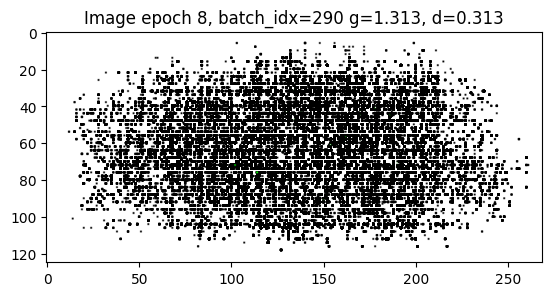

In [ ]:
from train_clouds_neural import RGBAImageDataset

gan_model = GAN()
trainer = L.Trainer(max_epochs=100)
trainer.fit(gan_model)

In [9]:
dataset = RGBAImageDataset(root_dir='images')

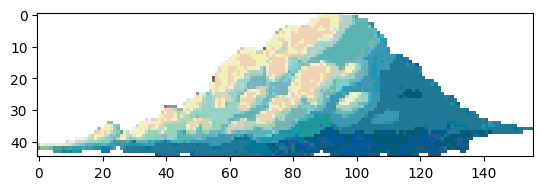

In [11]:
plt.imshow(dataset[3])